# NSLKDD Dataset Cleaning

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

The features spreadsheet contains  the name of each feature as well as a brief description of what information each feature stores. 

In [8]:
features_df = pd.read_excel("Features.xlsx",index_col="#")
features_df.head()

,Feature,Feature Name,Description,Type,Value Type,Ranges (Between both train and test)
#,,,,,,
1,duration,Duration,Length of time duration of the connection,Continuous,Integers,0 - 54451
2,protocol_type,Protocol Type,Protocol used in the connection,Categorical,Strings,NaN
3,service,Service,Destination network service used,Categorical,Strings,NaN
4,flag,Flag,Status of the connection – Normal or Error,Categorical,Strings,NaN
5,src_bytes,Src Bytes,Number of data bytes transferred from source t...,Continuous,Integers,0 - 1379963888


The "Feature" column of this dataframe can be used to create a list of the features in the same order they appear in the dataset.

In [9]:
feature_list = features_df["Feature"].values
feature_list

array(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_hot_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'difficulty_level'],
      dtype=object)

In [10]:
len(feature_list)

43

Of these features the following are categorical and require encoding:
* <code>protocol_type</code>: Protocol used in the connection (3 categories)
* <code>service</code>: Destination network service used (70 categories)
* <code>flag</code>:  Status of the connection (11 categories)
* <code>class</code>: Classification of the traffic input (23 categories)

The <code>class</code> feature contains all attack types which needs to be encoded for five-class classification.

In [11]:
# Five class classification 
DoS_attacks = ['back','land','neptune','teardrop','smurf','pod','apache2','processtable','mailbomb','worm','udpstorm']
Probe_attacks = ['ipsweep','portsweep','nmap','satan','saint','mscan']
U2R_attacks = ['rootkit','buffer_overflow','loadmodule','perl','ps','xterm','sqlattack']
R2L_attacks = ['warezclient','guess_passwd','ftp_write','multihop','imap','warezmaster','phf','spy','snmpgetattack',
              'httptunnel','snmpguess','named','sendmail','xlock','xsnoop'] 

In [12]:
def encode_target(class_feature):
    """Returns the encoded integer for five-class classification
       0 - Benign 
       1 - DoS Attack 
       2 - Probe Attack
       3 - U2R Attack 
       4 - R2L Attack"""
    
    if class_feature == "normal": return 0
    elif class_feature in DoS_attacks: return 1 
    elif class_feature in Probe_attacks: return 2
    elif class_feature in U2R_attacks: return 3
    elif class_feature in R2L_attacks: return 4
    else: return np.nan

In [13]:
def clean_nslkdd_dataset(data):

    # Drop difficulty level as it was derived 
    data = data.drop("difficulty_level", axis=1)

    # Drop num_outbounds_cmds as it always zero
    data = data.drop("num_outbound_cmds", axis=1)

    # Encode categorical features using one-hot encoding 
    dum_df = pd.get_dummies(data[["protocol_type","service","flag"]])
    data = data.drop(["protocol_type","service","flag"],axis=1)
    data = pd.concat([data,dum_df],axis=1)
    
    # Create Five-class Classification Target
    data["target"] = np.vectorize(encode_target)(data["class"])
    
    # Drop original class feature
    data = data.drop("class", axis=1)
    
    # Return cleaned data set
    return data 

Reading in and cleaning the train and test data

In [14]:
train_data = pd.read_csv("KDDTrain+.txt",names = feature_list)
test_data = pd.read_csv("KDDTest+.txt",names = feature_list)

In [15]:
combined_data = pd.concat([train_data,test_data])
cleaned_data = clean_nslkdd_dataset(combined_data)
cleaned_train_data = cleaned_data[0:len(train_data)]
cleaned_test_data = cleaned_data[len(train_data):]

Exploring the target class distribution in both the train and test data

In [16]:
cleaned_train_data["target"].value_counts().sort_index()

0    67343
1    45927
2    11656
3       52
4      995
Name: target, dtype: int64

In [18]:
cleaned_train_data.shape

(125973, 122)

In [108]:
cleaned_test_data["target"].value_counts().sort_index()

0    9711
1    7460
2    2421
3      67
4    2885
Name: target, dtype: int64

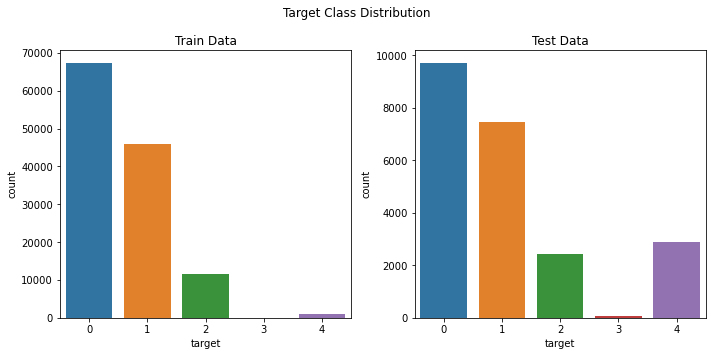

In [109]:
fig , axs = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

fig.suptitle("Target Class Distribution")

sns.countplot(x = 'target', data = cleaned_train_data, ax=axs[0])
axs[0].set_title("Train Data")

sns.countplot(x = 'target', data = cleaned_test_data, ax=axs[1])
axs[1].set_title("Test Data")

plt.tight_layout()
plt.show()

In [15]:
# Exporting Data 
cleaned_train_data.to_csv("nslkdd_train_cleaned.csv",index=False)
cleaned_test_data.to_csv("nslkdd_test_cleaned.csv",index=False)